# Распознавание объектов с помощью YOLO v3 на Tensorflow 2.0
До Yolo большинство подходов к распознаванию объектов заключалось в попытках адаптировать классификаторы к распознаванию. В YOLO, распознавание объектов было реализовано как задача регрессии к раздельным ограничивающим рамкам, с которыми связаны вероятности принадлежности к разным классам.

# Что такое YOLO?
YOLO – это передовая сеть для распознавания объектов (object detection), разработанная Джозефом Редмоном (Joseph Redmon). Главное, что отличает ее от других популярных архитектур – это скорость. Модели семейства YOLO действительно быстрые, намного быстрее R-CNN и других. Это значит, что мы можем распознавать объекты в реальном времени.

YOLO преобразовала задачу распознавания объектов к единой задаче регрессии. Она проходит прямо от пикселей изображения до координат содержащих рамок и вероятностей классов. Таким образом, единая CNN предсказывает множество содержащих рамок и вероятности классов для этих рамок.

YOLO – это алгоритм распознавания объектов с использованием алгоритмов
глубокого обучения. Он был представлен в конце 2015 года. Его преимущество
заключается в скорости обработки данных перед R-CNN и Fast R-CNN, где YOLO с
несколько меньшей точностью, но более высокой скоростью работы успешно
распознает объекты на видео.
YOLO разработана для нейронной сети на основе DarkNet. DarkNet хранит уже
обученные веса в собственном формате.

Поскольку YOLO смотрит на изображение только один раз, плавающее окно – это неправильный подход. Вместо этого, все изображение разбивается с помощью сетки на ячейки размером 𝑆∗𝑆. После этого каждая ячейка отвечает за предсказание нескольких вещей

Во-первых, каждая ячейка отвечает за предсказание нескольких содержащих рамок и показателя уверенности (confidence) для каждой из них – другими словами, это вероятность того, что данная рамка содержит объект. Если в какой-то ячейке сетки объектов нет, то очень важно, чтобы confidence для этой ячейки был очень малым.

Когда мы визуализируем все эти предсказания, мы получаем карту всех объектов и набор содержащих рамок, ранжированных по их confidence.

Во-вторых, каждая ячейка отвечает за предсказание вероятностей классов. Это не значит, что какая-то ячейка содержит какой-то объект, это всего лишь вероятность. Таким образом, если ячейка сети предсказывает автомобиль, это не значит, что он там есть, но это значит, что если там есть какой-то объект, то это автомобиль.

В YOLO для предсказания содержащих рамок используются якорные рамки (anchor boxes). Их основная идея заключается в предопределении двух разных рамок, называемых якорными рамками или формой якорных рамок. Это позволяет нам ассоциировать два предсказания с этими якорными рамками. В общем, мы можем использовать и большее количество якорных рамок (пять или даже больше). Якоря были рассчитаны на датасете COCO с помощью k-means кластеризации.

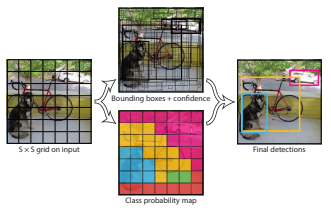

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2023-06-06 09:39:24--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  46.1MB/s    in 5.5s    

2023-06-06 09:39:29 (42.9 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



Создаем папку для хранения весов

In [ ]:
!rm -rf checkpoints
!mkdir checkpoints

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

from absl import logging
from itertools import repeat

from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU
from tensorflow.keras.layers import MaxPool2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.losses import sparse_categorical_crossentropy
from google.colab import files
from google.colab.patches import cv2_imshow

In [ ]:
yolo_iou_threshold   = 0.6 #эта переменная хранит пороговое значение IoU (Intersection over Union), используемое моделью YOLOv3 во время обнаружения объекта. Он определяет, насколько должно существовать перекрытие между прогнозируемой ограничивающей рамкой и ограничивающей рамкой истинности, чтобы они считались обнаруживающими один и тот же объект.
yolo_score_threshold = 0.6 #эта переменная хранит пороговое значение оценки достоверности, используемое моделью YOLOv3 во время обнаружения объекта. Он определяет минимальный уровень достоверности, необходимый для того, чтобы обнаруженный объект считался действительным.

weightsyolov3 = 'yolov3.weights' # в этой переменной хранится имя файла, содержащего предварительно обученные веса для модели YOLOv3.
weights= 'checkpoints/yolov3.tf' #предварительно обученные веса для модели YOLOv3.
size= 416             # в этой переменной хранится размер входных изображений, которые будут переданы в модель YOLOv3 для обнаружения объектов. Изображения большего размера обычно обеспечивают более точное обнаружение, но также требуют большего времени обработки.
checkpoints = 'checkpoints/yolov3.tf'
num_classes = 80      # количество классов, которые модель YOLOv3 обучена распознавать. В этом случае существует 80 различных классов объектов, которые может обнаружить модель.

Список слоев в YOLOv3 FCN — Fully Convolutional Network

In [ ]:
YOLO_V3_LAYERS = [
  'yolo_darknet', #это первый уровень в сети, который выполняет некоторую начальную обработку входного изображения.
  'yolo_conv_0', #это сверточный слой, который применяет набор фильтров к выходным данным предыдущего слоя.
  'yolo_output_0', #этот слой генерирует первый набор прогнозов для присутствия объектов на изображении.
  'yolo_conv_1', #это еще один сверточный слой, который применяет больше фильтров к выходным данным предыдущего слоя.
  'yolo_output_1', #этот слой генерирует второй набор прогнозов для присутствия объектов на изображении.
  'yolo_conv_2', #еще один сверточный слой, который применяет еще больше фильтров к выходным данным предыдущего слоя.
  'yolo_output_2', #этот слой генерирует окончательный набор прогнозов для присутствия объектов на изображении.
                 ]

Очень трудно загрузить веса с помощью чисто функционального API, поскольку порядок слоев в Darknet и tf.keras различаются. Здесь лучшее решение – создание подмоделей в keras. Для сохранения подмоделей рекомендуется использовать Checkpoint'ы Tensorflow, поскольку они официально поддерживаются Tensorflow.

Вот функция для загрузки весов из оригинальной тренированной модели YOLO в Darknet:

In [ ]:
def load_darknet_weights(model, weights_file): #Определение функции для загрузки весов Darknet в модель Keras
  wf = open(weights_file, 'rb') #Откройте файл весов в двоичном режиме чтения
  major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5) #Прочитайте основную, второстепенную, ревизию, просмотренную и неиспользуемую переменную из файла весов, используя numpy
  layers = YOLO_V3_LAYERS #Получите YOLO_V3_LAYERS из модели, в которую мы хотим загрузить веса.

  for layer_name in layers:
    sub_model = model.get_layer(layer_name) # Получить субмодель, соответствующую текущему слою
    for i, layer in enumerate(sub_model.layers): # Пройтись по всем слоям этой субмодели
      if not layer.name.startswith('conv2d'): # Если этот слой не является слоем свертки, пропустите его
        continue
      batch_norm = None  # Получить слой пакетной нормализации (если таковой имеется), соответствующий данному слою свертки
      if i + 1 < len(sub_model.layers) and \
            sub_model.layers[i + 1].name.startswith('batch_norm'):
        batch_norm = sub_model.layers[i + 1]

      logging.info("{}/{} {}".format(  # Вывести информацию о текущем слое
        sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

      filters = layer.filters # Получить количество фильтров, размер фильтра и входные размеры для этого слоя свертки
      size = layer.kernel_size[0]
      in_dim = layer.input_shape[-1]

      if batch_norm is None: # Если для данного слоя свертки нет слоя пакетной нормализации, считываем смещение свертки из файла весов
        conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
      else:  # Если для этого слоя свертки существует слой пакетной нормализации, считайте веса пакетной нормализации из файла весов
        bn_weights = np.fromfile(
          wf, dtype=np.float32, count=4 * filters)

        bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]] # Переформировать веса нормализации партии и изменить их порядок по мере необходимости

      conv_shape = (filters, in_dim, size, size) # Получение формы весов свертки и чтение весов свертки из файла весов
      conv_weights = np.fromfile(
        wf, dtype=np.float32, count=np.product(conv_shape))

      conv_weights = conv_weights.reshape( # Переформировать веса свертки и изменить их порядок по мере необходимости
        conv_shape).transpose([2, 3, 1, 0])

      if batch_norm is None: # Установите веса текущего слоя, используя веса свертки и веса смещения/пакетной нормализации
        layer.set_weights([conv_weights, conv_bias])
      else:
        layer.set_weights([conv_weights])
        batch_norm.set_weights(bn_weights)

  assert len(wf.read()) == 0, 'не удалось прочитать все данные' #Проверьте, все ли данные в файле весов были прочитаны, и закройте файл.
  wf.close()

Функция для расчета пересечения относительно объединения

In [ ]:
def interval_overlap(interval_1, interval_2): # Определяем функцию для вычисления длины пересечения двух интервалов
  x1, x2 = interval_1   # Распаковываем значения кортежей в переменные
  x3, x4 = interval_2
  if x3 < x1: # Если правая граница первого интервала меньше левой границы второго, то интервалы не пересекаются
    return 0 if x4 < x1 else (min(x2,x4) - x1)
  else:   # Иначе, если левая граница первого интервала меньше правой границы второго, то интервалы пересекаются
    return 0 if x2 < x3 else (min(x2,x4) - x3)

def intersectionOverUnion(box1, box2): # Определяем функцию для вычисления коэффициента IoU между двумя прямоугольниками
  intersect_w = interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax]) # Вычисляем длину пересечения прямоугольников вдоль оси X и Y
  intersect_h = interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
  intersect_area = intersect_w * intersect_h  # Вычисляем площадь пересечения прямоугольников

  w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin  # Вычисляем ширину и высоту каждого из прямоугольников
  w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

  union_area = w1*h1 + w2*h2 - intersect_area  # Вычисляем площадь объединения двух прямоугольников по формуле S_union = S_box1 + S_box2 - S_intersect
  return float(intersect_area) / union_area # Вычисляем коэффициент IoU как отношение площади пересечения к площади объединения двух прямоугольников

Эта функция принимает изображение, результаты модели обнаружения объектов и список имен классов. Она рисует ограничительные рамки вокруг обнаруженных объектов на изображении и добавляет текст, указывающий класс и доверительный балл для каждого объекта. Функция изменяет входное изображение на месте и возвращает измененное изображение.

In [ ]:
def draw_outputs(img, outputs, class_names): # Функция принимает изображение ('img'), результаты модели обнаружения объектов ('outputs') и список имен классов ('class_names').
  boxes, score, classes, nums = outputs # Переменная 'outputs' содержит четыре массива: boxes, score, classes и nums. Эти массивы содержат информацию об обнаруженных объектах на изображении.
  boxes, score, classes, nums = boxes[0], score[0], classes[0], nums[0] # Поскольку мы обрабатываем только одно изображение за раз, мы можем просто взять первый элемент из каждого массива (т.е. boxes[0], score[0], classes[0] и nums[0]).
  wh = np.flip(img.shape[0:2]) # Получите ширину и высоту изображения, перевернув порядок первых двух элементов кортежа формы.
  for i in range(nums):  # Перебо все обнаруженых объектов на изображении.
  # Получите координаты левого верхнего и правого нижнего углов ограничительной рамки вокруг объекта. Мы умножаем нормализованные координаты в массиве 'boxes' на ширину и высоту изображения, чтобы получить координаты в пикселях.
    x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
    x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
    img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)  # Нарисуйте прямоугольник вокруг объекта с помощью функции OpenCV cv2.rectangle(). Прямоугольник рисуется на переменной 'img', которая будет изменена на месте.
    img = cv2.putText(img, '{} {:.4f}'.format(
      class_names[int(classes[i])], score[i]),
      x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    # Добавьте текст к изображению, указывающий класс объекта и его доверительный балл.
    # Текст добавляется с помощью функции OpenCV cv2.putText().
    # Имя класса и доверительный балл получаются из массивов 'class_names' и 'score'массивов, соответственно. Мы используем функцию 'int' для преобразования идентификатора класса в массиве 'classes' в целое число перед индексированием в массив 'class_names'.
  return img # ну и возвращение модифицированного изображения

Используется пакетная нормализация (batch normalization), чтобы нормализовать результаты для ускорения тренировки. К сожалению, tf.keras.layers.BatchNormalization работает не очень хорошо для transfer learning, поэтому здесь предлагается другое решение этой проблемы.

Эта пользовательская реализация BatchNormalization добавляет дополнительное условие для проверки необходимости нормализации слоя (т.е. во время обучения). В частности, она использует аргумент обучения, переданный в метод вызова, и объединяет его с атрибутом обучаемости слоя с помощью логической операции AND. Если результат равен True, то слой нормализуется во время обучения; в противном случае он не нормализуется во время вывода.

In [ ]:
class BatchNormalization(tf.keras.layers.BatchNormalization): # Пользовательский слой BatchNormalization, который наследуется от tf.keras.layers.BatchNormalization.
  def call(self, x, training=False):
    if training is None: training = tf.constant(False)  # Используйте логическое И для объединения аргумента `training` с атрибутом `trainable` слоя. Это гарантирует, что слой будет нормализован только во время обучения, а не во время вывода.
    training = tf.logical_and(training, self.trainable)
    return super().call(x, training) # Вызовите метод `call` родительского класса и передайте измененный аргумент `training`.

Данный кусочек определяет якорные рамки для YOLO (You Only Look Once) алгоритма обнаружения объектов на изображениях. Якорные рамки - это набор заранее определенных прямоугольников разных размеров и соотношений сторон, которые используются для выявления объектов на изображении.

В данном коде определены значения координат центров якорных рамок в пикселях, а затем они были нормализованы к координатам от 0 до 1 путем деления на размер изображения (416x416). Также определены маски якорных рамок, которые указывают, какие рамки будут использоваться для каждого уровня карты признаков в YOLO модели. В данном случае, первый уровень будет использовать якорные рамки с индексами 6, 7 и 8, второй уровень - с индексами 3, 4 и 5, а третий уровень - с индексами 0, 1 и 2.

In [ ]:
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                        (59, 119), (116, 90), (156, 198), (373, 326)], np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

Для каждого масштаба мы определяем три якорные рамки для каждой ячейки.

* 0,1,2 – мы будем использовать три первые якорные рамки
* 3,4,5 – мы используем четвертую, пятую и шестую рамки
* 6,7,8 – мы используем седьмую, восьмую и девятую рамки

# Реализация YOLO v3
- Вот как выглядит ее структура

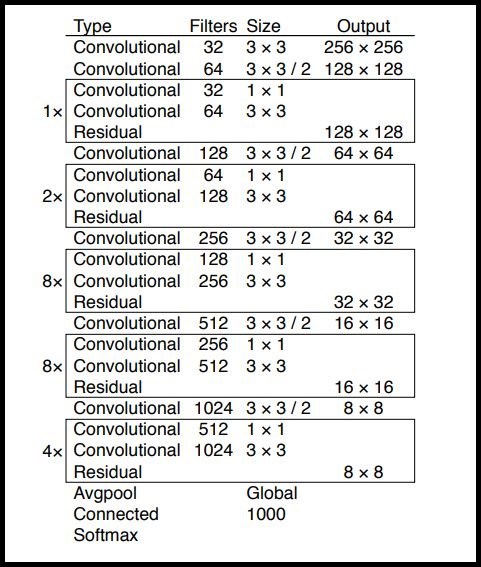

- Здесь основная идея – использовать только сверточные слои. Их там 53, так что проще всего создать функцию, в которую мы будем передавать важные параметры, изменяющиеся от слоя к слою.

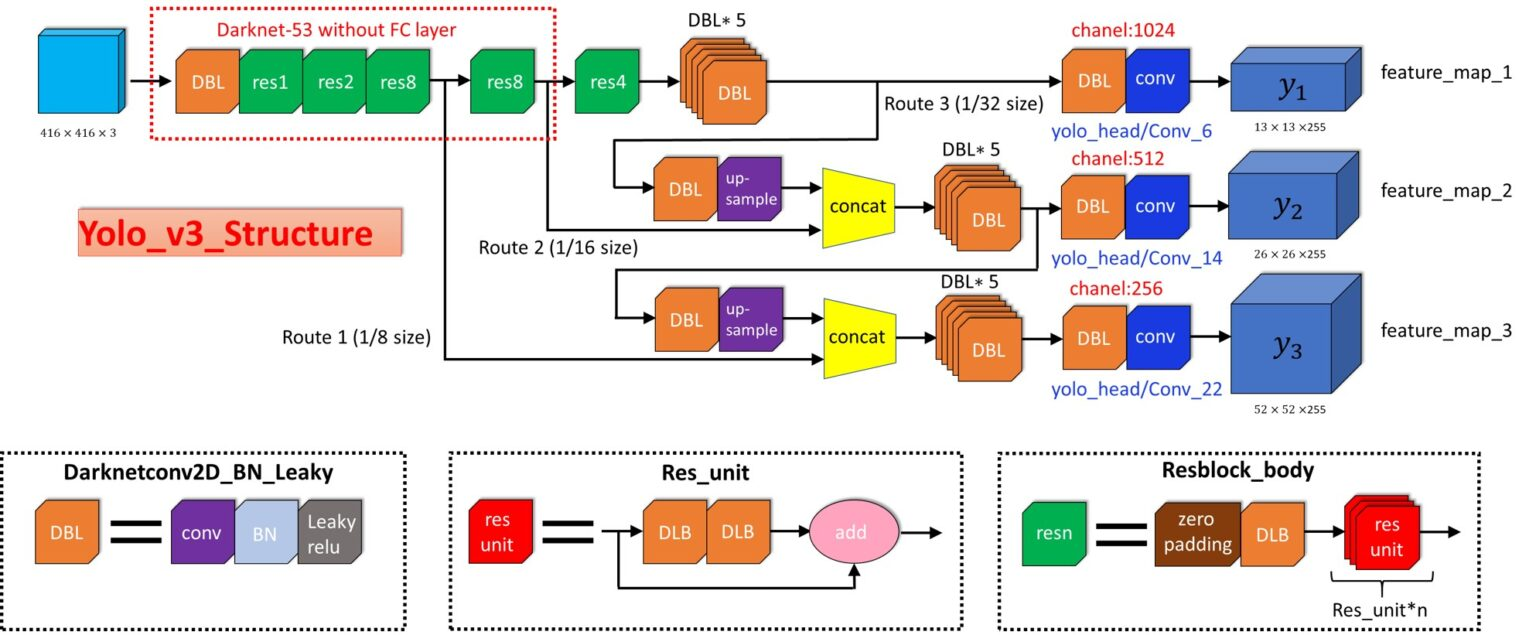

Остаточные блоки (Residual blocks) на диаграмме архитектуры YOLOv3 используются для обучения признакам. Остаточный блок состоит из нескольких сверточных слоев и обходных путей:

Архитектура строится с помощью Функционального API, простого в использовании. С ним мы можем легко задавать ветви в нашей архитектуре (блок ResNet) и легко использовать одни и те же слои несколько раз внутри архитектуры.

In [ ]:
def DarknetConv(x, filters, size, strides=1, batch_norm=True): # Сверточный слой Darknet
  if strides == 1: # Определяем набивку на основе шагов
    padding = 'same'
  else:
    x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # Добавьте нулевое добавление к входному тензору
    padding = 'valid'
  x = Conv2D(filters=filters, kernel_size=size, # Выполнить операцию свертки
          strides=strides, padding=padding,
          use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
  if batch_norm: # Если включена пакетная нормализация, примените ее и добавьте функцию активации
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
  return x

def DarknetResidual(x, filters): # Остаточный слой Darknet
  previous  = x # Сохраняем предыдущий выходной тензор для быстрого подключения
  x = DarknetConv(x, filters // 2, 1) # Выполните две свертки 1x1, а затем свертку 3x3.
  x = DarknetConv(x, filters, 3)
  x = Add()([previous , x])
  return x


def DarknetBlock(x, filters, blocks): # Darknet блок
  x = DarknetConv(x, filters, 3, strides=2) # Выполните свертку 3x3 с шагом 2 и последующими остаточными блоками
  for _ in repeat(None, blocks):
    x = DarknetResidual(x, filters)
  return x


def Darknet(name=None): # Определение архитектуры Darknet
  x = inputs = Input([None, None, 3]) # Определение входного тензора
  x = DarknetConv(x, 32, 3) # Конволюционные слои Darknet с остаточными блоками
  x = DarknetBlock(x, 64, 1)
  x = DarknetBlock(x, 128, 2)
  x = x_36 = DarknetBlock(x, 256, 8)
  x = x_61 = DarknetBlock(x, 512, 8)
  x = DarknetBlock(x, 1024, 4)
  return tf.keras.Model(inputs, (x_36, x_61, x), name=name) # Возвращаем результаты трех разных шкал

def YoloConv(filters, name=None): # Сверточный слой Yolo
  def yolo_conv(x_in):
    if isinstance(x_in, tuple): # Если входные данные являются кортежем, выполните операцию апсемплинга и конкатенации
      inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
      x, x_skip = inputs

      x = DarknetConv(x, filters, 1) # Выполните свертку 1x1 с последующей апсемплингом и конкатенацией
      x = UpSampling2D(2)(x)
      x = Concatenate()([x, x_skip])
    else:
      x = inputs = Input(x_in.shape[1:])

    x = DarknetConv(x, filters, 1) # Выполнить пять сверток 1x1 и 3x3
    x = DarknetConv(x, filters * 2, 3)
    x = DarknetConv(x, filters, 1)
    x = DarknetConv(x, filters * 2, 3)
    x = DarknetConv(x, filters, 1)
    return Model(inputs, x, name=name)(x_in)
  return yolo_conv

def YoloOutput(filters, anchors, classes, name=None): # Выходной слой Yolo.  Она принимает входные параметры: filters - число фильтров, anchors - число anchor boxes, classes - число классов объектов, а также имя модели
  def yolo_output(x_in): # Три свертки 3x3 для получения конечного результата. Функция определяет логику работы модели YOLO. Она принимает на вход тензор x_in, который представляет собой изображение. Затем она производит ряд операций свертки, решейпинга и объединения данных для получения выходных значений модели.
    x = inputs = Input(x_in.shape[1:])
    x = DarknetConv(x, filters * 2, 3)
    x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
    x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                        anchors, classes + 5)))(x)
    return tf.keras.Model(inputs, x, name=name)(x_in)
  return yolo_output

def yolo_boxes(pred, anchors, classes): #Функция yolo_boxes берет на вход предсказанные значения, anchor boxes и количество классов объектов. Внутри функции происходит разделение входных значений на четыре тензора:
  # координаты центра якоря, ширины и высоты якоря, оценку вероятности принадлежности к классу и оценку вероятности наличия объекта. Затем выполняются ряд математических операций, чтобы получить окончательные координаты границ объектов (bbox), оценку вероятности и оценку вероятности каждого класса.
  grid_size = tf.shape(pred)[1] #Получение размеров сетки
  box_xy, box_wh, score, class_probs = tf.split(pred, (2, 2, 1, classes), axis=-1) #Разделите тензор предсказаний на координаты x-y, ширину-высоту, оценку объективности и вероятности классов

  box_xy = tf.sigmoid(box_xy) #Применить фнкцию активации- сигмоиду к координатам x-y, оценке объективности и вероятности класса
  score = tf.sigmoid(score)
  class_probs = tf.sigmoid(class_probs)
  pred_box = tf.concat((box_xy, box_wh), axis=-1) #Объедините координаты x-y и ширину-высоту, чтобы получить прогнозируемые ограничительные рамки

  grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size)) #Создание сетки координат
  grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)

  box_xy = (box_xy + tf.cast(grid, tf.float32)) /  tf.cast(grid_size, tf.float32) #Добавьте сетку к координатам x-y, чтобы получить абсолютные позиции ограничивающей рамки
  box_wh = tf.exp(box_wh) * anchors #Масштабирование ширины и высоты по размерам якорного блока

  box_x1y1 = box_xy - box_wh / 2 # Вычислить левую верхнюю и правую нижнюю координаты ограничительных рамок
  box_x2y2 = box_xy + box_wh / 2
  bbox = tf.concat([box_x1y1, box_x2y2], axis=-1) #Объедините координаты сверху-слева и снизу-справа, чтобы получить окончательные прогнозы граничного поля

  return bbox, score, class_probs, pred_box # Ну и тут возвращаем все прогнозы в качестве выходных данных

Подавление не-максимумов.
Алгоритм non-maximum suppression (NMS) для выбора наиболее значимых объектов в изображении, обнаруженных с помощью YOLO (You Only Look Once) алгоритма.

YOLO разделяет изображение на сетку и для каждой ячейки сетки определяет вероятность наличия объекта, координаты ограничивающей рамки объекта, а также его класс. Но может быть несколько ячеек, которые содержат информацию об одном и том же объекте, поэтому применяется NMS, чтобы объединить перекрывающиеся рамки и отбросить более слабые детекции.

Функция nonMaximumSuppression принимает следующие аргументы:
* outputs: список YOLO выходов для каждого уровня сети
* anchors: якорные рамки, используемые при обучении сети
* masks: маски для каждого уровня сети
* classes: список классов, на которые обучена сеть

Далее происходят следующие действия:

Создаются списки для хранения рамок, уверенности в наличии объекта и типа объекта (список списков)
Для каждого уровня сети происходит изменение формы выходного значения и добавление его в соответствующий список
Списки объединяются в один тензор для дальнейшего использования в NMS
Умножаются уверенность и вероятности классов для получения оценок (scores)
Используется функция (combined_non_max_suppression) из TensorFlow для применения NMS к оценкам, с целью выбрать наиболее значимые объекты
Возвращаются отобранные рамки, оценки, классы и количество обнаруженных объектов (valid_detections)

In [ ]:
def nonMaximumSuppression(outputs, anchors, masks, classes):
  boxes, conf, out_type = [], [], [] # Создание списков для рамок, уверенности и типа объекта

  for output in outputs: # Для каждого выхода из YOLO изменение формы и добавление в соответствующий список
    boxes.append(tf.reshape(output[0], (tf.shape(output[0])[0], -1, tf.shape(output[0])[-1])))
    conf.append(tf.reshape(output[1], (tf.shape(output[1])[0], -1, tf.shape(output[1])[-1])))
    out_type.append(tf.reshape(output[2], (tf.shape(output[2])[0], -1, tf.shape(output[2])[-1])))

  bbox = tf.concat(boxes, axis=1) # Объединение списков в один тензор для дальнейшего использования в NMS
  confidence = tf.concat(conf, axis=1)
  class_probs = tf.concat(out_type, axis=1)

  scores = confidence * class_probs # Умножение уверенности и вероятностей классов для получения оценок (scores)

  boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(  # Применение NMS к оценкам с помощью функции combined_non_max_suppression() из TensorFlow
    boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
    scores=tf.reshape(
        scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
    max_output_size_per_class=100,
    max_total_size=100,
    iou_threshold=yolo_iou_threshold, # порог перекрытия IoU для объединения рамок
    score_threshold=yolo_score_threshold # порог оценки для отброса слабых детекций
  )

  return boxes, scores, classes, valid_detections # Возвращение отобранных рамок, оценок, классов и количества обнаруженных объектов

Основная функция, создающая всю модель:

Тут описывается архитектура нейронной сети, которая является одним из самых популярных и эффективных методов детектирования объектов на изображениях.

Функция YoloV3() создает модель, используя входные параметры size (размер изображения), channels (количество каналов в изображении), anchors (якорные рамки, используемые для детектирования объектов) и masks (маски для выбора соответствующих якорных рамок).

Модель состоит из нескольких блоков:

* Слой Darknet, который представляет собой сверточную нейронную сеть, основанную на архитектуре Darknet-53.
* Три блока YoloConv, каждый из которых выполняет несколько сверток с целью извлечения признаков из различных масштабов изображения.
* Три блока YoloOutput, генерирующих выходные данные для каждого блока YoloConv.
* В блоке Lambda используются функции yolo_boxes() и nonMaximumSuppression(), которые принимают выходные данные output_0, output_1 и output_2 из блоков YoloOutput, преобразуют их в ящики (bounding boxes) и выполняют подавление немаксимальных значений для получения окончательных предсказаний модели.
* Если параметр training равен True, то функция возвращает модель, которая будет использоваться в процессе обучения. Если training равен False, то функция возвращает модель, которая будет использоваться для выполнения предсказаний на новых данных.

In [ ]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
          masks=yolo_anchor_masks, classes=80, training=False):
  x = inputs = Input([size, size, channels])

  x_36, x_61, x = Darknet(name='yolo_darknet')(x)

  x = YoloConv(512, name='yolo_conv_0')(x)
  output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

  x = YoloConv(256, name='yolo_conv_1')((x, x_61))
  output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

  x = YoloConv(128, name='yolo_conv_2')((x, x_36))
  output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

  if training:
    return Model(inputs, (output_0, output_1, output_2), name='yolov3')

  boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                  name='yolo_boxes_0')(output_0)
  boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                  name='yolo_boxes_1')(output_1)
  boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                  name='yolo_boxes_2')(output_2)

  outputs = Lambda(lambda x: nonMaximumSuppression(x, anchors, masks, classes),
                  name='nonMaximumSuppression')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

  return Model(inputs, outputs, name='yolov3')

In [ ]:
def YoloLoss(anchors, classes=80, ignore_thresh=0.5): # Определите функцию, которая возвращает другую функцию для вычисления потерь YOLO
    def yolo_loss(y_true, y_pred): # Определите фактическую функцию потерь, которая принимает `y_true` и `y_pred`.
        # преобразование всех предварительных выходов
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes( # Извлечение предсказанных границ, оценок объектности, вероятностей классов и координат ящиков из `y_pred`.
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # преобразование выходов
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1) # Разделите `y_true` на истинные граничные поля, оценки объектности и индексы классов.
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2 # Вычислить истинные координаты центра и размеры ограничительных рамок
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1] # Вычислите масштаб потерь для каждого ящика на основе его размера

        # инвертирование уравнений
        grid_size = tf.shape(y_true)[1] # Вычислить размер сетки, создать тензор сетки и настроить координаты истинного центра относительно сетки
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors) # Масштабируйте истинные размеры ящика по размерам якорного ящика
        true_wh = tf.where(tf.math.is_inf(true_wh),
                           tf.zeros_like(true_wh), true_wh)

        # считаем маски
        obj_mask = tf.squeeze(true_obj, -1) # Вычислить маску, указывающую, какие истинные ячейки должны быть проигнорированы
        true_box_flat = tf.boolean_mask(true_box, tf.cast(obj_mask, tf.bool))
        best_iou = tf.reduce_max(broadcast_iou(
            pred_box, true_box_flat), axis=-1)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # считаем потери
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        # сумма (batch, gridx, gridy, anchors)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3)) # Суммируйте компоненты функции потерь и верните общий убыток
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss # Возвращаем функцию для вычисления потерь YOLO
    return yolo_loss

Следующая функция трансформирует целевые выводы к кортежу (tuple) следующей формы:
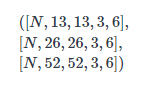

Здесь N – количество меток в пакете (batch), а 6 представляет [x, y, w, h, obj, class] содержащих рамок.

In [ ]:
@tf.function # Определите функцию TensorFlow, которая преобразует истинные целевые значения для соответствия формату вывода YOLOv3
def transform_targets_for_output(y_true, grid_size, anchor_idxs, classes):

  N = tf.shape(y_true)[0]   # Get the batch size

  y_true_out = tf.zeros( # Создаем пустой тензор для преобразованных целей
      (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

  anchor_idxs = tf.cast(anchor_idxs, tf.int32) # Приведение индексов якорей к целым числам

  indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True) # Инициализировать массивы для хранения индексов и обновлений
  updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
  idx = 0
  for i in tf.range(N): # Перебираем каждый элемент в выборке
    for j in tf.range(tf.shape(y_true)[1]):
      if tf.equal(y_true[i][j][2], 0): # Если оценка объективности равна нулю, пропустить
        continue
      anchor_eq = tf.equal( # Проверьте, совпадает ли индекс якоря с одним из индексов якоря, указанных в маске
        anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

      if tf.reduce_any(anchor_eq):
        box = y_true[i][j][0:4] # Получить координаты коробки и координаты центра
        box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

        anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32) # Получение индекса якоря и координат сетки
        grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

        indexes = indexes.write( # Добавить индекс и обновление в массивы
            idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
        updates = updates.write(
          idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
        idx += 1

  return tf.tensor_scatter_nd_update( # Обновление преобразованного целевого тензора с индексами и обновлениями
    y_true_out, indexes.stack(), updates.stack())


def transform_targets(y_train, anchors, anchor_masks, classes): # Функция, которая преобразует все истинные целевые значения для каждого уровня выходного сигнала модели YOLOv3
  outputs = []
  grid_size = 13

  anchors = tf.cast(anchors, tf.float32) # Приведите размеры якорей к плавающим значениям и вычислите площадь
  anchor_area = anchors[..., 0] * anchors[..., 1]
  box_wh = y_train[..., 2:4] - y_train[..., 0:2] # Вычислить ширину и высоту поля для всех аннотаций
  box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                    (1, 1, tf.shape(anchors)[0], 1))
  box_area = box_wh[..., 0] * box_wh[..., 1] # Вычислите площадь каждого ящика и пересечение между каждым ящиком и якорем
  intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
    tf.minimum(box_wh[..., 1], anchors[..., 1])
  iou = intersection / (box_area + anchor_area - intersection)
  anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32) # Найти индекс якоря с наибольшим IoU для каждой аннотации
  anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

  y_train = tf.concat([y_train, anchor_idx], axis=-1) # Добавить индекс якоря к истинному тензору цели

  for anchor_idxs in anchor_masks: # Пройдитесь по каждой якорной маске и преобразуйте истинные цели для данного уровня выхода
    outputs.append(transform_targets_for_output(
      y_train, grid_size, anchor_idxs, classes))
    grid_size *= 2

  return tuple(outputs) # [x, y, w, h, obj, class]


def preprocess_image(x_train, size): # Определите функцию, которая предварительно обрабатывает входное изображение, изменяя его размер до заданного и масштабируя значения пикселей в диапазоне [0, 1].
  return (tf.image.resize(x_train, (size, size))) / 255

Теперь мы создаем экземпляр нашей модели, загружаем веса и имена классов. В датасете COCO их 80.

In [ ]:
yolo = YoloV3(classes=num_classes) # Инстанцировать модель YOLOv3 с заданным количеством классов

load_darknet_weights(yolo, weightsyolov3) # Загрузка предварительно обученных весов для модели YOLOv3 из файла формата darknet

yolo.save_weights(checkpoints) # Сохранить веса модели YOLOv3 в файл контрольных точек

class_names =  ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
    "banana","apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake","chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop",
    "mouse","remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
    "refrigerator","book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

- Для того, чтобы протестировать алгоритм, нужно загрузить изображение

In [ ]:
img = tf.image.decode_image(open(name, 'rb').read(), channels=3)
img = tf.expand_dims(img, 0)
img = preprocess_image(img, size)

In [ ]:
boxes, scores, classes, nums = yolo(img)

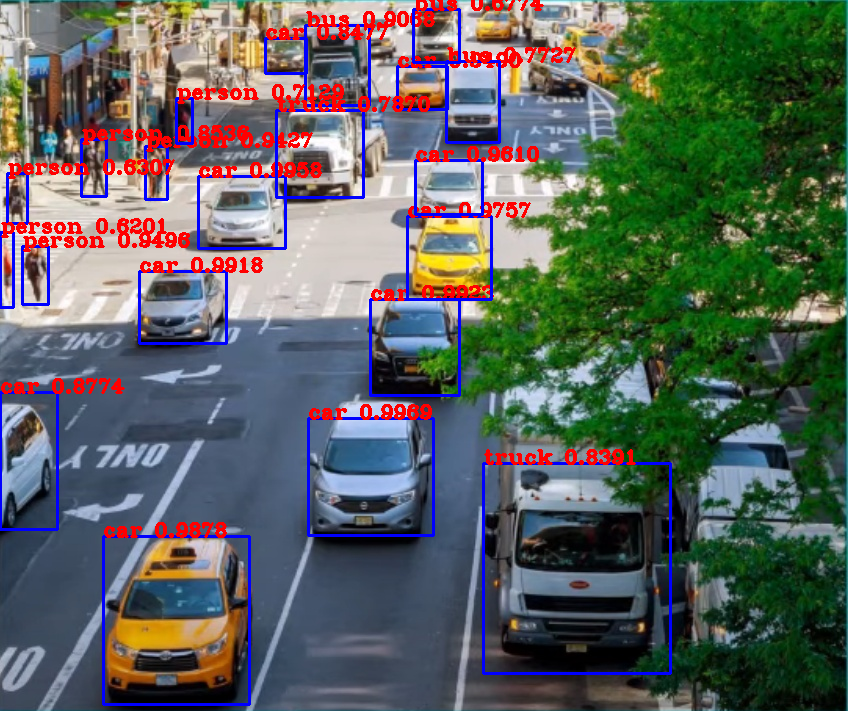

In [ ]:
img = cv2.imread(name)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
cv2.imwrite('output.jpg', img) # выходное обработанное изображение
cv2_imshow(img)